Kaggle_Competition_AIffel_Daejeon
===

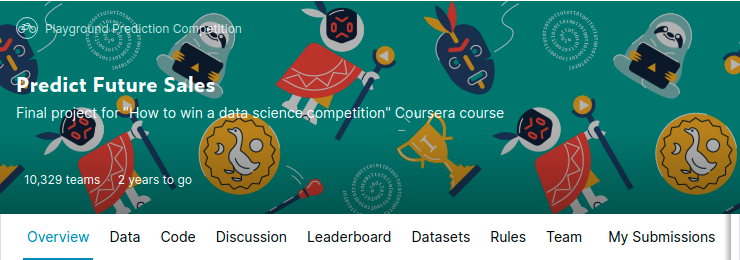

### 13조: TL(Triple Lee)
### 팀원: 이용복, 이주헌, 이혜성

#### 데이터: [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data) 

#### 협업툴: Google_Colab(Main), Gather(Main), Notion,(sub), GitHub(sub)

#### 하이퍼 파라미터 튜닝: 그리드 탐색

#### 사용한 모델: LGBMRegressor

#### 참조한 노드
- F8: 데이터를 한눈에! Visualization
- F11: 가랏, 몬스터볼! 전설의 포켓몬 찾아 삼만리
- F14: 다양한 데이터 전처리 기법
- F17: 어라, 이 시계열 데이터 이상한데? - Anomaly Detection
- E9: 나의 첫 번째 캐글 경진대회, 무작정 따라해보기



### 목차
- **데이터 불러오기**
    - 라이브러리 실행
    - train, test, sales, item, item category 데이터 불러오기
    
    
- **EDA 및 데이터 시각화**
    - item_price 가 300000넘는 것 - Novelties
    - item_cnt_day 가 2000넘는 것 - Outlier
    
    
- **데이터 병합 처리**
    - Train: 결측치 있는지 확인, 새로운 Feature 추가
    - Test: 그대로 사용
    
    
- **하이퍼파리미터 조정 : 그리드 탐색**
    - Grid : 'n_estimators': \[100, 200, 300,\]'max_depth': \[10, 20, 30\]
    
    
- **Model Fitting**
    - LGBMRegressor, random state=2020, n_estimators=300, max_depth=10
    
    
- **예측값 저장**
    - submission_lgbm_RMSLE_0..csv



---

## 1. 데이터 불러오기
#### 라이브러리 실행

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
from os.path import join

import warnings
warnings.filterwarnings("ignore")
import missingno as msno

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import datetime

#### sales_train.csv 불러온 후 확인해보기

In [2]:
train_path = os.getenv('HOME') + '/aiffel/kaggle_competition/data/sales_train.csv'
original_train_data = pd.read_csv(train_path)
train = original_train_data.copy()
print(train.shape)
train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


#### test.csv 불러온 후 확인해보기

In [3]:
test_path = os.getenv('HOME') + '/aiffel/kaggle_competition/data/test.csv'
original_data = pd.read_csv(test_path)
test = original_data.copy()
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


#### items.csv 불러와 저장하기

In [4]:
items_path = os.getenv('HOME') + '/aiffel/kaggle_competition/data/items_en.csv'
items_data = pd.read_csv(items_path)

#### shops.csv 불러와 저장하기

In [5]:
shops_path = os.getenv('HOME') + '/aiffel/kaggle_competition/data/shops_en.csv'
shops_data = pd.read_csv(shops_path)

#### item_categories.csv 불러와 저장하기

In [6]:
categories_path = os.getenv('HOME') + '/aiffel/kaggle_competition/data/item_categories_en.csv'
categories_data = pd.read_csv(categories_path)

---
## 2. EDA 및 데이터 시각화
#### date_block_num에 따라 item_cnt_day의 변화 살펴보기

<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_day'>

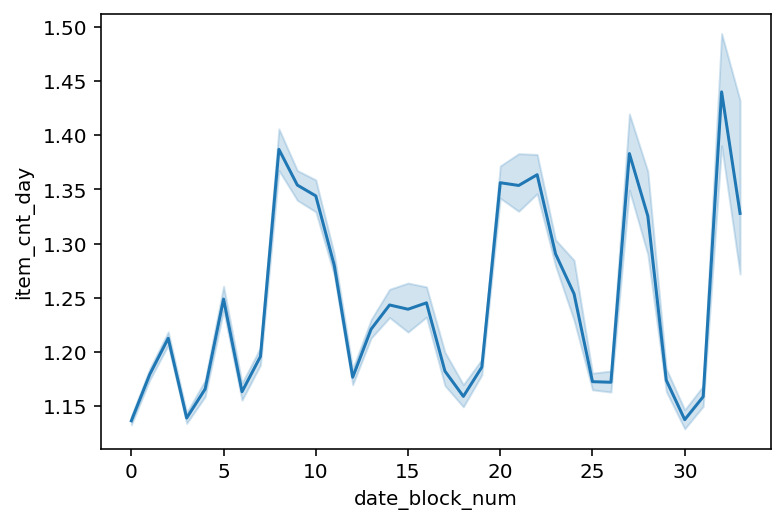

In [7]:
sns.lineplot(data=train, y="item_cnt_day", x="date_block_num")

> 시간이 월별로 지남에 따라 item_cnt_day는 변동을 가지며 증가하는 것으로 보인다.

#### item_price에 따른 item_cnt_day 전체데이터 확인해보기

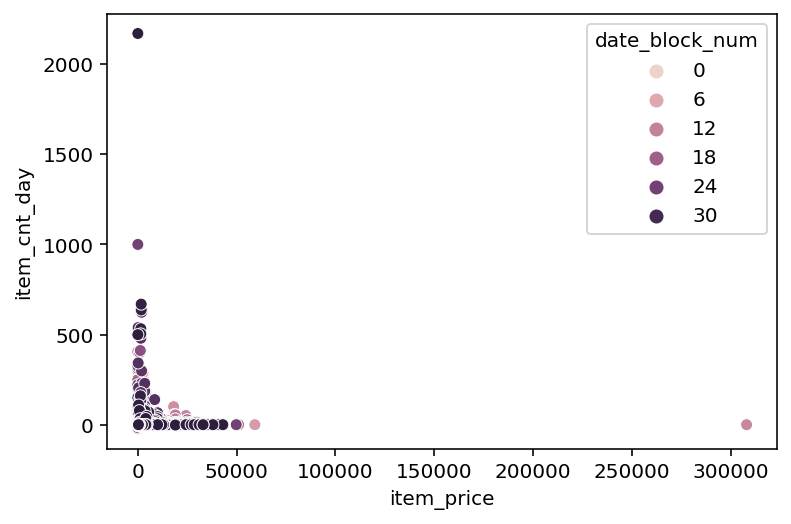

In [8]:
sns.scatterplot(data=train, y="item_cnt_day", x="item_price", hue="date_block_num")
plt.show()

> item_cnt_day가 2000을 넘는 것과 item_price가 300000을 넘는 것. <br/>
두 개의 이상치가 있는 것으로 보인다. 하지만 이것이 outlier(극단치)인지 아니면 Novelties(특이치)인지 데이터 특성을 고려해 판단해보자

#### item_price가 300000이 넘는 데이터를 확인

In [9]:
train[train['item_price'] >= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


#### item_id = 6066이 어떤 데이터인지 확인

In [10]:
items_data[items_data['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


#### 유사한 이름을 가진 item_id = 6065를 포착

In [11]:
items_data[items_data['item_id'] == 6065]

,item_name,item_id,item_category_id
6065,Radmin 3 - 1 лиц.,6065,75


#### 대략 얼마 정도에 팔리고 있는지 확인

In [12]:
train[train['item_id'] == 6065]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
291238,21.03.2013,2,22,6065,1299.0,1.0
291260,22.03.2013,2,22,6065,1299.0,1.0
318708,11.03.2013,2,25,6065,1299.0,1.0
370177,18.04.2013,3,12,6065,1299.0,1.0
375067,06.04.2013,3,6,6065,1299.0,1.0
379230,12.04.2013,3,22,6065,1299.0,1.0
379232,20.04.2013,3,22,6065,1299.0,2.0
487026,05.05.2013,4,54,6065,1299.0,1.0
542238,07.06.2013,5,29,6065,1299.0,1.0
679923,29.07.2013,6,22,6065,1299.0,1.0


> 팔리고 있는 Radmin 3의 가격은 1299원이다. лиц이란 의미를 찾아보니 명이라는 뜻이다. 따라서, Radmin 3 - 522 лиц는 1299 X 522 = 678078로 307980보다 2배 이상 비싸지만 많은 인원이 구매하여 가격을 할인해줬을 것이라는 것을 고려하면 이상치로 보기 어려울 듯 하다.

#### item_cnt_day가 2000을 넘는 데이터 확인

In [13]:
train[train['item_cnt_day'] >= 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


#### item_id가 11373인 품목이 무엇인지 확인

In [14]:
items_data[items_data['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Delivery to the delivery point (Boxberry),11373,9


Boxberry를 배달하는 가격이다.

#### 가격에 따라 팔리는 양을 확인해보기

In [15]:
train[train['item_id'] == 11373]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58323,08.01.2013,0,12,11373,1000.00,1.0
58324,31.01.2013,0,12,11373,97.80,5.0
176790,01.02.2013,1,12,11373,229.00,1.0
176791,04.02.2013,1,12,11373,130.00,1.0
302468,29.03.2013,2,12,11373,139.50,2.0
...,...,...,...,...,...,...
2909829,07.10.2015,33,12,11373,855.00,2.0
2909830,06.10.2015,33,12,11373,208.80,5.0
2909831,05.10.2015,33,12,11373,140.75,16.0
2909832,02.10.2015,33,12,11373,648.50,2.0


<AxesSubplot:xlabel='item_price', ylabel='item_cnt_day'>

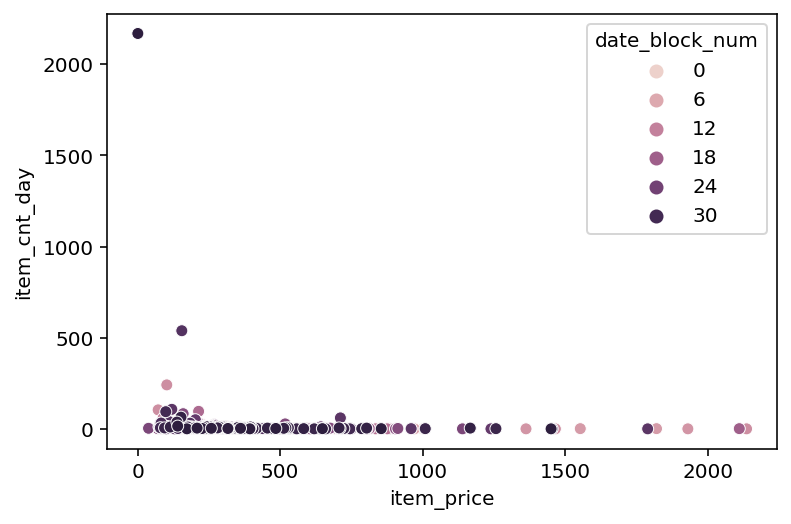

In [16]:
sns.scatterplot(data=train[train['item_id'] == 11373], y="item_cnt_day", x="item_price", hue="date_block_num")

> item_price의 가격이 낮아지면 팔리는 양이 많이지는 것으로 보이긴 하나, 일반적으로 팔리는 양보다 많으므로 이상치라고 판단하고 지우기로 하였다.

In [17]:
train = train.drop([2909818])
train[train['item_cnt_day'] >= 2000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


#### date_block_num에 따른 item_cnt_day와 item_cnt_day의 scatter plot

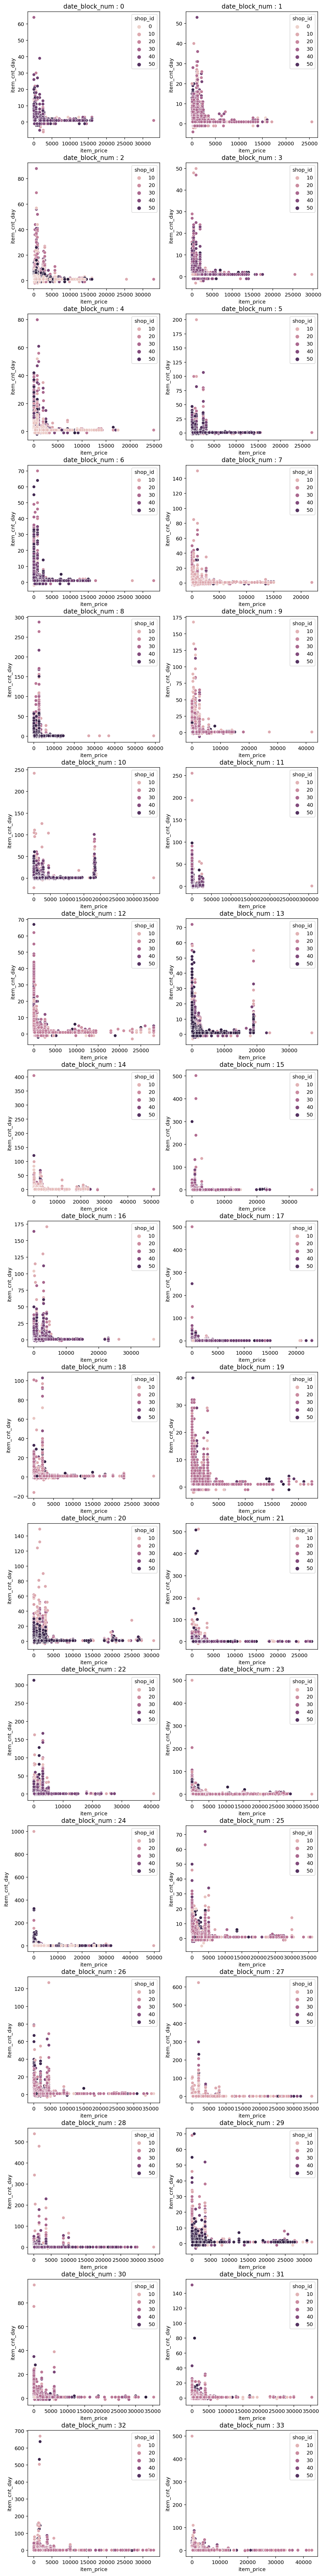

In [18]:
plt.figure(figsize=(10, 90))

for i in range(34):
    plt.subplot(17, 2, i+1)
    plt.title('date_block_num : %d' %i )
    sns.scatterplot(data=train[train['date_block_num']==i], y="item_cnt_day", x="item_price", hue="shop_id")
    
plt.show()

---
## 3. 데이터 병합처리 

### Train data Feature 처리

#### train data에 결측치가 있는지 확인

In [19]:
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

- 결측치가 없다

### Year, Month 컬럼을 생성을 위한 과정

#### date컬럼의 타입 확인

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935848 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 156.8+ MB


#### date컬럼의 타입 변경

In [21]:
train['date_dt'] = pd.to_datetime(train['date'], format="%d.%m.%Y")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935848 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            object        
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   date_dt         datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 179.2+ MB


#### year컬럼과 month컬럼을 date_dt를 이용하여 만듦

In [22]:
train_dt = train.copy()
train_dt['year'] = train_dt['date_dt'].dt.year 
train_dt['month'] = train_dt['date_dt'].dt.month 
train_dt

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_dt,year,month
0,02.01.2013,0,59,22154,999.00,1.0,2013-01-02,2013,1
1,03.01.2013,0,25,2552,899.00,1.0,2013-01-03,2013,1
2,05.01.2013,0,25,2552,899.00,-1.0,2013-01-05,2013,1
3,06.01.2013,0,25,2554,1709.05,1.0,2013-01-06,2013,1
4,15.01.2013,0,25,2555,1099.00,1.0,2013-01-15,2013,1
...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,2015-10-10,2015,10
2935845,09.10.2015,33,25,7460,299.00,1.0,2015-10-09,2015,10
2935846,14.10.2015,33,25,7459,349.00,1.0,2015-10-14,2015,10
2935847,22.10.2015,33,25,7440,299.00,1.0,2015-10-22,2015,10


In [23]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935848 entries, 0 to 2935848
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            object        
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   date_dt         datetime64[ns]
 7   year            int64         
 8   month           int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 224.0+ MB


#### 'date_block_num', 'year', 'month' 세 컬럼만 남기기 

In [24]:
train_dt = train_dt[['date_block_num', 'year', 'month']]
train_dt = train_dt.drop_duplicates('date_block_num', keep='first')
train_dt = train_dt.set_index('date_block_num')
train_dt = train_dt.reset_index()
train_dt

,date_block_num,year,month
0,0,2013,1
1,1,2013,2
2,2,2013,3
3,3,2013,4
4,4,2013,5
5,5,2013,6
6,6,2013,7
7,7,2013,8
8,8,2013,9
9,9,2013,10


### 새로운 인덱스 ID 생성을 위한 과정
#### shop_id와 item_id가 같을 경우 sum을 해준 데이터 프레임 만들기

In [25]:
train_idx = train.groupby(by=['shop_id','item_id'], as_index=False).sum()
train_idx

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,0,30,9,2385.0,31.0
1,0,31,7,3038.0,11.0
2,0,32,7,2431.0,16.0
3,0,33,3,2082.0,6.0
4,0,35,11,2964.0,15.0
...,...,...,...,...,...
424119,59,22154,0,999.0,1.0
424120,59,22155,6,149.0,1.0
424121,59,22162,415,6234.0,16.0
424122,59,22164,160,4344.0,6.0


#### 인덱스를 리셋해준 후  'shop_id', 'item_id'로 인덱스를 만들어줌

In [26]:
train_idx = train_idx.reset_index()
train_idx = train_idx.set_index(['shop_id', 'item_id'])
train_idx

index  date_block_num  item_price  item_cnt_day
shop_id item_id                                                  
0       30            0               9      2385.0          31.0
        31            1               7      3038.0          11.0
        32            2               7      2431.0          16.0
        33            3               3      2082.0           6.0
        35            4              11      2964.0          15.0
...                 ...             ...         ...           ...
59      22154    424119               0       999.0           1.0
        22155    424120               6       149.0           1.0
        22162    424121             415      6234.0          16.0
        22164    424122             160      4344.0           6.0
        22167    424123              48      1196.0           4.0

[424124 rows x 4 columns]

#### 'index'컬럼을 'ID'컬럼으로 바꾸어 줌

In [27]:
train_idx=train_idx.rename({'index': 'ID'}, axis='columns')
train_idx

ID  date_block_num  item_price  item_cnt_day
shop_id item_id                                                  
0       30            0               9      2385.0          31.0
        31            1               7      3038.0          11.0
        32            2               7      2431.0          16.0
        33            3               3      2082.0           6.0
        35            4              11      2964.0          15.0
...                 ...             ...         ...           ...
59      22154    424119               0       999.0           1.0
        22155    424120               6       149.0           1.0
        22162    424121             415      6234.0          16.0
        22164    424122             160      4344.0           6.0
        22167    424123              48      1196.0           4.0

[424124 rows x 4 columns]

#### 'shop_id', 'item_id', 'ID' 컬럼만 남김

In [28]:
train_ridx = train_idx.reset_index()
train_ridx = train_ridx[['shop_id', 'item_id', 'ID']]
train_ridx

,shop_id,item_id,ID
0,0,30,0
1,0,31,1
2,0,32,2
3,0,33,3
4,0,35,4
...,...,...,...
424119,59,22154,424119
424120,59,22155,424120
424121,59,22162,424121
424122,59,22164,424122


#### 'shop_id', 'item_id'를 기준으로 합치기 (ID 컬럼을 부여해주기 위함)

In [29]:
train_df = train.groupby(by=['date_block_num','shop_id','item_id'], as_index=False).sum()
train_df = train_df.rename({'item_cnt_day' : 'item_cnt_month'}, axis=1)
train_df 

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,0,32,884.0,6.0
1,0,0,33,1041.0,3.0
2,0,0,35,247.0,1.0
3,0,0,43,221.0,1.0
4,0,0,51,257.0,2.0
...,...,...,...,...,...
1609119,33,59,22087,357.0,6.0
1609120,33,59,22088,238.0,2.0
1609121,33,59,22091,179.0,1.0
1609122,33,59,22100,629.0,1.0


#### train data에 virt_id를 붙이기

In [30]:
train_df = pd.merge(train_df, train_ridx, on=['shop_id', 'item_id'], how='left')
train_df

,date_block_num,shop_id,item_id,item_price,item_cnt_month,ID
0,0,0,32,884.0,6.0,2
1,0,0,33,1041.0,3.0,3
2,0,0,35,247.0,1.0,4
3,0,0,43,221.0,1.0,8
4,0,0,51,257.0,2.0,10
...,...,...,...,...,...,...
1609119,33,59,22087,357.0,6.0,424095
1609120,33,59,22088,238.0,2.0,424096
1609121,33,59,22091,179.0,1.0,424097
1609122,33,59,22100,629.0,1.0,424099


#### 'shop_id', 'item_id', 'ID', 'item_cnt_month' 네 가지만 남겨주기

In [31]:
train_df = train_df[['shop_id', 'item_id', 'ID', 'item_cnt_month']]
train_df

,shop_id,item_id,ID,item_cnt_month
0,0,32,2,6.0
1,0,33,3,3.0
2,0,35,4,1.0
3,0,43,8,1.0
4,0,51,10,2.0
...,...,...,...,...
1609119,59,22087,424095,6.0
1609120,59,22088,424096,2.0
1609121,59,22091,424097,1.0
1609122,59,22100,424099,1.0


#### trian_x와 train_y 설정해주기

In [32]:
train_x = train_df.drop(['item_cnt_month'], axis=1)
train_y =  train_df['item_cnt_month']

print(train_x.shape)
print(train_y.shape)

(1609124, 3)
(1609124,)


## Test data 처리

In [33]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [34]:
print(test.shape)

(214200, 3)


## 4. 하이퍼파리미터 조정 : 그리드 탐색

### 그리드 파라미터 설정

In [35]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}
model = LGBMRegressor(random_state=2020)

### 최적의 그리드를 찾아주는 함수 만들기

In [36]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

    model.fit(train_x, train_y)
    params = model.cv_results_['params']
    score = model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')
    return results

함수에 모델과 train_x와 train_y, 파라미터 그리드를 넣어주고 실행

In [37]:
my_GridSearch(model, train_x, train_y, param_grid)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  2.2min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,max_depth,n_estimators,score,RMSLE
2,10,300,-66.381474,8.147483
5,20,300,-66.385262,8.147715
8,30,300,-66.389853,8.147997
1,10,200,-66.391180,8.148078
4,20,200,-66.393146,8.148199
7,30,200,-66.398053,8.148500
3,20,100,-66.457312,8.152135
6,30,100,-66.458238,8.152192
0,10,100,-66.459322,8.152259


## 5. 모델 fitting

In [38]:
model = LGBMRegressor(max_depth=10, n_estimators=300, random_state=2020)
model.fit(train_x, train_y)
prediction = model.predict(test)
prediction

array([3.47772946, 2.77466991, 1.44382534, ..., 1.38287346, 1.38786815,
       1.39146601])

## 6. 나온 예측값을 저장

In [39]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_competition/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['item_cnt_month'] = prediction
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.')
submission.to_csv(submission_csv_path, index=False)